In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

from ngram import *
from baselines import *
from error_analysis import *
pd.options.mode.chained_assignment = None

### Load Annotated Data

In [2]:
task = 'aggression'
xtype = 'comments'
ytype = 'plurality'
n_classes = 3

time: 2.76 ms


In [3]:
data = load_comments_and_labels(task)
X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 4min 17s


### Hyper-Parameter tuning

In [4]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')),
])

time: 1.54 ms


In [5]:
param_grid = {
    'vect__max_features': (500, 5000, 10000, 50000, None), 
    'vect__ngram_range': ((1,5),),  
    'vect__analyzer' : ('char',), 
}

tune (X_train, y_train, cv_pipeline, param_grid, roc_scorer, n_jobs=8, verbose=True)


Best parameters set found:
{'vect__max_features': 50000, 'vect__analyzer': 'char', 'vect__ngram_range': (1, 5)} 0.93753474452


Grid scores:
0.89493 (+/-0.00000) for {'vect__max_features': 500, 'vect__analyzer': 'char', 'vect__ngram_range': (1, 5)}
0.92137 (+/-0.00000) for {'vect__max_features': 5000, 'vect__analyzer': 'char', 'vect__ngram_range': (1, 5)}
0.92864 (+/-0.00000) for {'vect__max_features': 10000, 'vect__analyzer': 'char', 'vect__ngram_range': (1, 5)}
0.93753 (+/-0.00000) for {'vect__max_features': 50000, 'vect__analyzer': 'char', 'vect__ngram_range': (1, 5)}
0.93548 (+/-0.00000) for {'vect__max_features': None, 'vect__analyzer': 'char', 'vect__ngram_range': (1, 5)}
time: 7min 23s


### Eval Best Pipeline

In [4]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 5.0, solver = 'lbfgs', multi_class= 'multinomial')),
])

time: 3.68 ms


In [5]:
model = optimal_pipeline.fit(X_train, y_train)
roc_df, spearman_df = test_cross(model, data, xtype)

time: 14min 27s


In [6]:
roc_df

,random,blocked,both
user,0.886667,0.923693,0.928509
article,0.886405,0.921597,0.914096
both,0.903202,0.930424,0.934095


time: 16 ms


In [7]:
spearman_df

,random,blocked,both
user,0.548472,0.755023,0.752281
article,0.247301,0.527955,0.458248
both,0.422439,0.696011,0.657407


time: 14.8 ms


### Does Adding Blocked Data Help predicting on Random Data?

#### User

In [8]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random']},
                {'nss': ['user'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.862
	Spearman: 0.556

Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.876
	Spearman: 0.540
time: 6min 46s


#### Article

In [9]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random']},
                {'nss': ['article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.834
	Spearman: 0.195

Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.870
	Spearman: 0.227
time: 6min 21s


## Does adding random and blocked data from one namespace help predict on random data from the other namespace?

#### User

In [10]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.876
	Spearman: 0.540

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.887
	Spearman: 0.548
time: 7min 6s


#### Article

In [11]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.870
	Spearman: 0.227

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.886
	Spearman: 0.247
time: 7min 1s


### Check Calibration

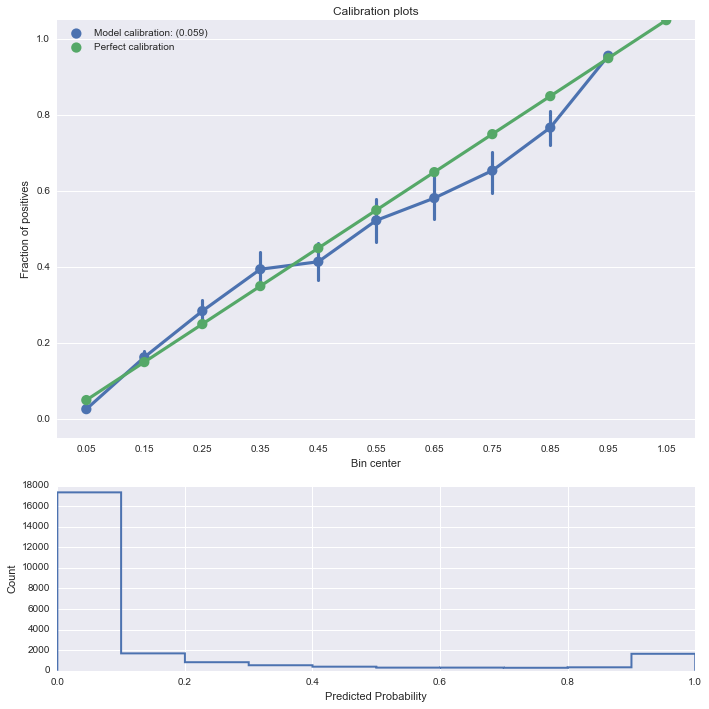

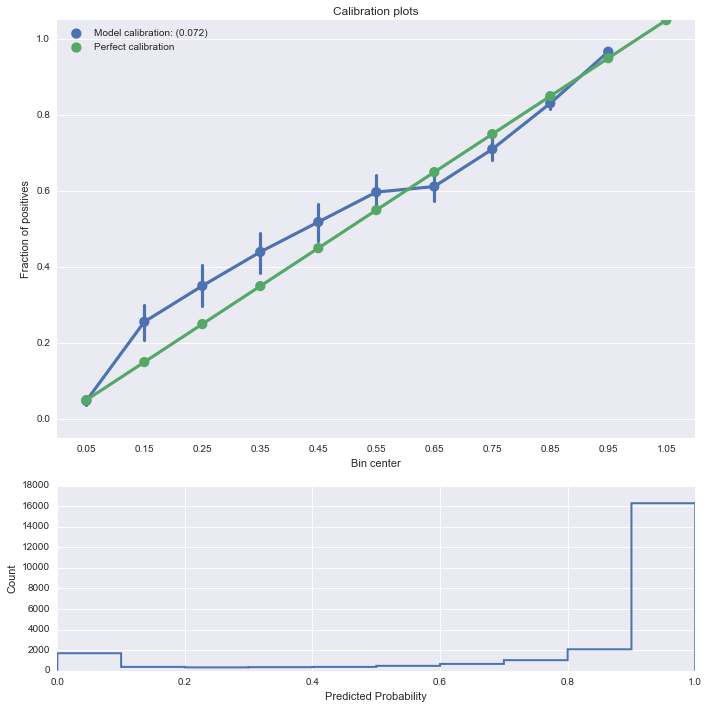

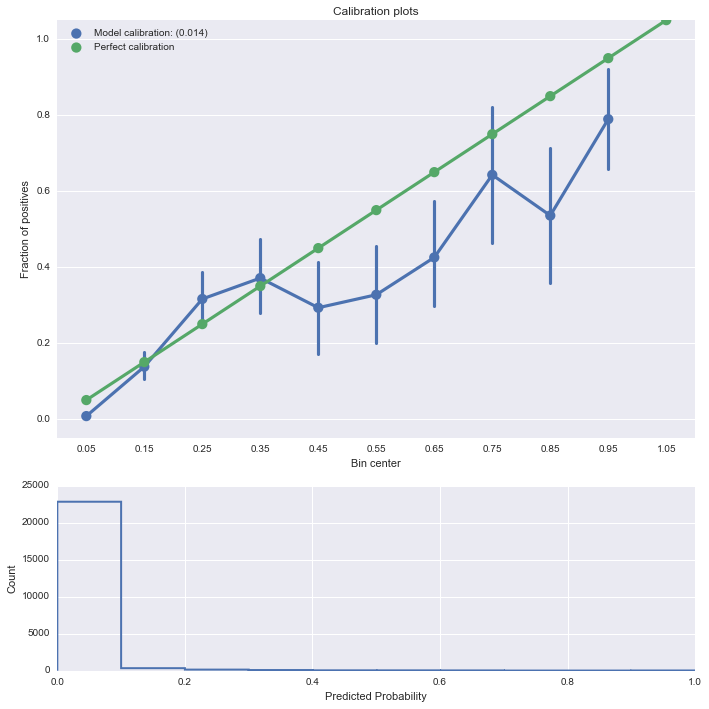

time: 1min 3s


In [12]:
y_test_oh = one_hot(y_test)
y_pred_ed = model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()

### Error Analysis

In [13]:
for i in classes:
    print('\n\n\nCLASS: ', i)
    over, under = get_errors(X_test, y_test_oh[:, i], y_pred_ed[:, i])
    print('\n\nOVER\n')
    print_errors(over, n=10)
    print('\n\nUNDER\n')
    print_errors(under, n=10)




CLASS:  0


OVER

COMMENT:
my buttholei love buttholes. they taste mmm goood. i will never stop vandalizing wikipedia. u no why?  cuz u dont tell me wat to do. k bye i hate you
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 HOPE YOUR HEAD GETS CUT OFF AND SOMEONE WIPES THERE ASS WITH IT AND THEN STABS YOU IN YOUR HEART!!! NO ONE CAN KEEP ME FROM HERE YOU DUMB PIECE OF SHIT, NOT YAMLA'S STUPID ASS OR YOU!!! NOW HURRY UP AND SIT IN SOME TRAFFIC SO I CAN SEE YOUR HEAD ROLL DOWN THE STREET
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 I kid you not, cunt.
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 Listen up. OK, listen up you god damn jerk. I'm really sick and tired of your shit. I'm sick of you stalking me all over wikipedia because I'm editing a page. Just because YOU don't like the edits I make, doesn't mean you have to bully and global block me each time I make an edit OK?? I'm not hurting and offending anyone, so why 

### Learning Curves!
How does adding more training data improve performance?

In [14]:
#ms, metrics = eval_adding_other_data(optimal_pipeline, None, None, X_test, y_test, X_train, y_train, roc_scorer)
#plot_adding_other_data(ms, metrics)

time: 1.32 ms


### Model Understanding

In [15]:
feature_names = np.array(model.named_steps['vect'].get_feature_names())
for i in classes:
    print('\n\nCLASS: ', i)
    
    try:
        coef = model.named_steps['clf'].coef_[i].ravel()
    except:
        coef = model.named_steps['clf'].coef_.ravel()
    most_pos_idx = np.argsort(coef)[-100:]
    most_pos = feature_names[most_pos_idx]
    print('STRONG POS: ')
    print(most_pos)
    most_neg_idx = np.argsort(coef)[:100]
    most_neg = feature_names[most_neg_idx]
    print('STRONG NEG: ')
    print(most_neg)



CLASS:  0
STRONG POS: 
[' di' 'um' 't.' 'ss' ' nigg' 'cum' ' foo' 'id' 'u ' 'umb' 'l ' 'nigg'
 'phil' 'cks' 'stu' 'hell' 'suck ' 'ick' ' li' 'enis' ' na' 'stop ' 't up'
 'fu' 'usti' ' fag' 'oro' 'ude' 'shit ' 'f' ' an' 'yo' 'uck' 'foo' 'y mo'
 ' peni' '""' 'cun' ' off' 'ole' 'ipp' 'penis' 're a ' 'dic' 'lls' ' die'
 'i hat' 'you' 'pi' 'cis' ' hate' 'nke' ' cun' ' rac' '!' 'itc' 'cunt'
 ' cunt' 'fuck ' 'itch' ' gay' 'gina' '*' ' shit' 'dou' ' dick' 'azi' ' id'
 'fag' 'ass' 'rap' 'hit' 'sh' 'mn' ' je' 'gay' 'lia' ' hell' 'ck' 'dam'
 ' fuck' 'moro' 'dick' ' suck' 'oron' 'hole' 'dio' ' fuc' 'crap' 'suck'
 ' ass' 'sex' 'idi' 'tard' 'fuck' 'shit' 'iot' 'fuc' 'upi' 'pid']
STRONG NEG: 
['. ' 'thank' 'hank' 'hi ' 'hello' 'ello' 'assu' ')' ' grea' ' "' 'ank'
 'tag' '/' 'lu' ' gre' ' whol' 'whol' 'bal' 'grea' 'log' 'unl' 'put' 'lp'
 'great' '. tha' ' but ' 'ank y' 'ok' 'pl' 'uff' 'than' ' hu' 'wish' ' sho'
 'roc' ' lis' 'ssu' 'pli' ') ' 'zin' 'so' 'rum' 'cess' 'hank ' ' fl' 'work'
 ' jo' 't, i'

### Final Model

In [16]:
X, y = assemble_data(data, xtype, ytype)
final_model = optimal_pipeline.fit(X, y)
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/aggression_ngram.pkl',
 '../../models/aggression_ngram.pkl_01.npy',
 '../../models/aggression_ngram.pkl_02.npy',
 '../../models/aggression_ngram.pkl_03.npy',
 '../../models/aggression_ngram.pkl_04.npy',
 '../../models/aggression_ngram.pkl_05.npy',
 '../../models/aggression_ngram.pkl_06.npy']

time: 7min 28s
